In [1]:
from typing import List, Dict, Set, Tuple, Optional
import numpy as np
import cv2
import random
from scipy.spatial import distance
import matplotlib.pyplot as plt
from tqdm import tqdm
from two_opt import TwoOpt
from two_point_five_opt import TwoPointFiveOpt
from three_opt import ThreeOpt
from python_tsp.exact import solve_tsp_dynamic_programming
import time

In [20]:
class DGWO(TwoOpt,TwoPointFiveOpt,ThreeOpt):
    """
    Implementation of the Discrete Grey Wolf Optimizer (DGWO) as described in
    https://doi.org/10.1016/j.asoc.2021.107298
    """

    def __init__(self,
        image: np.ndarray,
        patch_size: Tuple[int,int],
        iteration: int,
        num_wolves: int,
        verbose: Optional[bool]):
            
        super().__init__(image,patch_size,verbose)
        self.iteration = iteration
        self.history = {i:[] for i in range(len(self.all_graphs))}
        self.num_wolves = num_wolves

    def initialize(self,n:int,g: Dict[int, Set[int]]) -> List[List[int]]:
        """
        Initialize the initial population of grey wolves

        Arguments:
        n: number of grey wolves

        Return
        initial_population: the initial population of grey wolves
        """
        nodes = list(g.keys())
        initial_population = [random.sample(nodes,len(g)) for i in range(n)]
        return initial_population
        
    def get_fitness(self,population):
        """
        Gets the fitness of every wolf
        """
        population = population
        fitness = lambda x: len(self.build_path(x,self.adj_list,self.local_to_coords))

        return list(map(fitness,population))
    
    def get_distance(self,route):
        dist = 0
        for i in range(len(route)-1):
            dist += self.weight_matrix[route[i],route[i+1]]
            
        return dist
    
    def _optimize_one(self,i_g,g):
        """
        Optimize according to the discrete grey wolf optimizer
        """
        population = self.initialize(self.num_wolves,g)
        population = sorted(population, key=lambda x: len(self.build_path(x,self.adj_list,self.local_to_coords)))
        best_path = population[0]
        best_path_dist = len(self.build_path(population[0],self.adj_list,self.local_to_coords))

        for i in tqdm(range(self.iteration)):
            for j in range(self.num_wolves):
                for k in range(3):
                    d = random.randint(0, int(distance.hamming(population[k],population[j]) * len(g)))
                    population[j] = self.two_opt(population[j],d)          

            """
            This section is for statistics purposes
            """
            all_fitness = self.get_fitness(population)
            self.history[i_g].append(all_fitness)

            """
            Optimization continues here
            
            """
            population = sorted(population, key=lambda x: len(self.build_path(x,self.adj_list,self.local_to_coords)))
            next_best_path_dist = len(self.build_path(population[0],self.adj_list,self.local_to_coords))
            if best_path_dist > next_best_path_dist:
                best_path = population[0]
                best_path_dist = next_best_path_dist
                
        return self.build_path(best_path,self.adj_list,self.local_to_coords)

    def _optimize(self):
        self.seal_path = []
        self.traverse_path = []
        self.all_path_converted = []        

        for i, g in enumerate(self.all_graphs):
            path = self._optimize_one(i,g)
            path = self.build_path(path,self.adj_list,self.local_to_coords)
            self.seal_path.append(path)

        if len(self.seal_path) == 1:
            p = [self.mapping_r[local_node] for local_node in self.seal_path[0]]
            self.all_path_converted.append(p)
            return p        
        else:
            path = []
            path_weights, connect_paths = self.post_path(self.seal_path)
            path_weights[:,0] = 0
            crack_order, _ = solve_tsp_dynamic_programming(path_weights)

            for i in range(len(self.all_graphs)):
                path_converted = []
                path_converted = list(map(lambda x : self.mapping_r[x], self.seal_path[i]))
                self.all_path_converted.append(path_converted)

            path = []
            for i in range(len(self.all_path_converted)-1):
                path.extend(self.all_path_converted[i])
                traverse_path = connect_paths[(i,i+1)]
                path.extend(traverse_path)
                self.traverse_path.append(traverse_path)

            path.extend(self.all_path_converted[crack_order[-1]])

            return path

Preprocessing of graph completed
405


100%|██████████| 50/50 [01:27<00:00,  1.75s/it]

[2535, 2536, 2456, 2455, 2375, 2374, 2454, 2453, 2533, 2613, 2614, 2534, 2614, 2694, 2695, 2615, 2616, 2696, 2776, 2777, 2857, 2856, 2855, 2856, 2936, 2937, 2938, 2939, 2859, 2858, 2938, 3018, 3019, 3020, 3021, 3101, 3102, 3103, 3104, 3103, 3183, 3182, 3183, 3184, 3185, 3186, 3266, 3265, 3185, 3105, 3106, 3026, 3027, 3028, 3029, 2949, 3029, 3109, 3110, 3111, 3031, 3030, 2950, 2951, 2952, 3032, 3033, 2953, 2873, 2874, 2954, 2955, 3035, 3036, 3037, 3038, 2958, 2959, 3039, 3119, 3199, 3279, 3278, 3277, 3357, 3356, 3276, 3275, 3195, 3115, 3116, 3196, 3197, 3117, 3118, 3198, 3118, 3038, 3037, 3036, 3035, 3034, 3114, 3194, 3274, 3273, 3193, 3194, 3114, 3113, 3112, 3192, 3191, 3271, 3351, 3352, 3272, 3271, 3270, 3350, 3270, 3269, 3268, 3188, 3189, 3190, 3189, 3188, 3187, 3107, 3108, 3028, 3027, 3026, 3025, 3024, 3023, 3022, 2942, 2941, 2940, 3020, 3100, 3180, 3181, 3180, 3260, 3259, 3179, 3178, 3098, 3099, 3098, 3097, 3017, 3016, 3015, 3014, 3094, 3093, 3092, 3012, 2932, 2931, 3011, 3091, 317

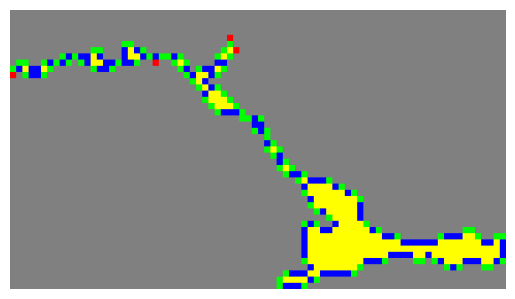

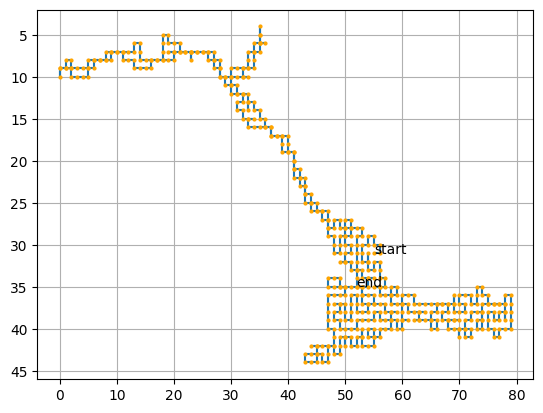

In [71]:
if __name__ == "__main__":
    num_runs = 1
    start_time = time.perf_counter()
    for i in range(num_runs):
        img = cv2.imread("./Crack500/train/mask/20160225_114503_641_361.png")
        if len(img.shape) == 3:
            img = np.any(img > 0, axis=-1)

        ps = (8,8)
        x = DGWO(img,ps,50,20,False)
        print(x.num_vertex)
        path = x._optimize()
        print(path)
        print(x.check_all_path())
        # x.get_statistics("Discrete Grey Wolf Bat Optimization",20,x.history)
        x.draw_path()

    end_time = time.perf_counter()
    print(f"Average time = {(end_time - start_time)/num_runs}")


In [ ]:
path = x.build_path(route,x.adj_list,x.local_to_coords)
path = [x.mapping_r[node] for node in path]
x.one_path_checker(path)
x.draw_path()